In [5]:
import numpy as np
from multiprocessing import Pool
import time
import matplotlib.pyplot as plt
import pandas as pd
import SGD_with_k_samples

In [7]:
# Loading the dataset
dataframe = pd.read_excel('dataset1/dataset1.xlsx')

X = dataframe['V'].sort_values()
X = (X - X.mean()) / X.std()
y = dataframe['AT'][X.index].values
y = (y - y.mean()) / y.std()

X = np.reshape(X.values, (-1, 1))

def polynomial_basis_function_transformation(X, h):
    powers = np.arange(h)
    X_poly = np.power(X, powers)
    return X_poly



In [9]:
def compute_gradient(args):
    """
    Compute the gradient of the loss function for a mini-batch of data.
    """
    X_batch, y_batch, alpha = args
    X_poly = polynomial_basis_function_transformation(X_batch, 4)
    m = len(y_batch)  # Mini-batch size
    predictions = X_poly.dot(alpha)  # Linear regression predictions
    errors = predictions - y_batch
    gradient = (1 / m) * X_poly.T.dot(errors)
    return gradient

def parallel_sgd_with_k_samples(X, y, alpha, learning_rate, epochs, num_threads, k):
    """
    Implements parallelized stochastic gradient descent with k samples.
    """
    mse_history = []
    time_taken = []
    n_samples = len(y)
    pool = Pool(processes=num_threads)  # Create a pool of workers
    start_time = time.time()

    for epoch in range(epochs):
        
        
        # Shuffle data
        indices = np.random.permutation(n_samples)
        X_shuffled = X[indices]
        y_shuffled = y[indices]
        X_poly = polynomial_basis_function_transformation(X_shuffled, 4)

        # Split data into mini-batches
        mini_batches = [
            (X_shuffled[i:i+k], y_shuffled[i:i+k], alpha)
            for i in range(0, n_samples, k)
        ]

        # Compute gradients in parallel
        gradients = pool.map(compute_gradient, mini_batches)

        # Average the gradients across all threads
        avg_gradient = np.mean(gradients, axis=0)

        # Update parameters (alpha)
        alpha -= learning_rate * avg_gradient

        # Calculate MSE
        mse = np.mean((X_poly.dot(alpha) - y) ** 2)  # MSE using the updated parameters
        mse_history.append(mse)

        # Calculate time taken for the epoch
        end_time = time.time()
        elapsed_time = end_time - start_time
        time_taken.append(elapsed_time)



    pool.close()
    pool.join()
    
    return mse_history, time_taken


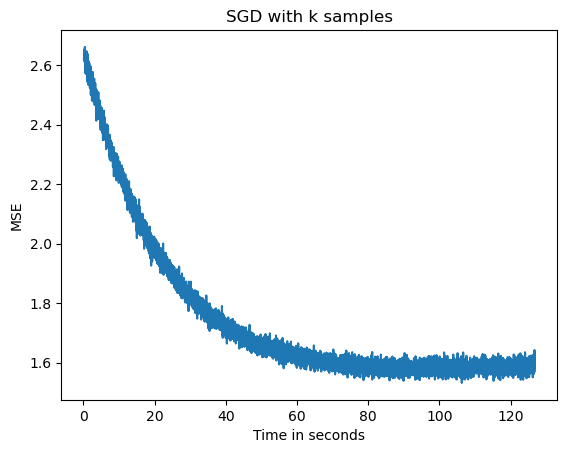

In [38]:
alpha = np.random.rand(4)  # Initial model parameters

# Hyperparameters
learning_rate = 0.0001
epochs = 10000
num_threads = 1  # Number of threads
k = 16  # Number of points each thread processes per batch

if __name__ == "__main__":
    mse,time = SGD_with_k_samples.parallel_sgd_with_k_samples(X, y, alpha, learning_rate, epochs, num_threads, k)
    plt.xlabel('Time in seconds')
    plt.ylabel('MSE')
    plt.title('SGD with k samples')
    plt.plot(time,mse)